# Interferometer

An interferometer is essentially two (or more) antennas whose signals we "interfere" with each other to extract the correlated information. Mathematically, **correlation** is an operation you can perform on two functions (say, $f$ and $g$), sliding one past the other and integrating up the product at each offset $\tau$:
\begin{equation}
\left[f\star g\right](\tau) \equiv \int{f(t)g^*(t-\tau)dt}.
\end{equation}
Here, we assume $f$ and $g$ are functions of time, but you can correlate functions of any coordinate (or any number of dimension) to get a correlation that is a function of the offset in each coordinate.

Correlation turns out to be intimately related to the **Fourier transform**. In fact, the correlation of two
functions is just the product (with a complex conjugation) of their respective Fourier transforms:
\begin{align}
\left[f\star g\right](\tau)&\equiv \int{f(t)g^*(t-\tau)dt}\\
& = \frac1{(2\pi)^2}\int\!\!\!\int{\tilde f(\omega_1)e^{i\omega_1 t}d\omega_1\,
                 \tilde g^*(\omega_2)e^{-i\omega_2(t-\tau)}d\omega_2\,dt}\\
& = \frac1{(2\pi)^2}\int\!\!\!\int{\tilde f(\omega_1)\tilde g^*(\omega_2)e^{i(\omega_1-\omega_2) t}
                e^{i\omega_2\tau}d\omega_1\,d\omega_2\,dt}\\
& = \frac1{2\pi}\int{\tilde f(\omega)\tilde g^*(\omega) e^{i\omega\tau}d\omega}.
\end{align}
As you see looking at the last line above, the correlation of $f$ and $g$ is, in fact, the inverse Fourier transform of $\tilde f(\omega)$ and $\tilde g^*(\omega)$, which were themselves the Fourier transforms of $f$
and $g^*$, respectively.

Correlation turns out to be just the tool for building a telescope out of multiple smaller antenna dishes.  Imagine the wavefront of an astrophysical source propagating down from the sky onto the ground where we've put two dishes. 
Since the dishes are not exactly the same distance from each source, there will be some time delay between when a signal reaches antenna 1 and antenna 2. This is known as the **geometric delay** and is typically denoted $\tau_g$. The geometric delay can be expressed as the amount of time it takes for light to cross the separation vector (which we typically call the **baseline** $\vec b_{12} \equiv \vec r_2 - \vec r_1$) between the two antennas:
\begin{equation}
\tau_{g} = \frac{\vec b\cdot \hat s}{c} = \frac{b\cos\theta}{c},
\end{equation}
where $\hat s$ is a unit vector pointing the direction of a source on the sky, $\theta$ is the angle that $\hat s$ makes with the baseline vector $\vec b$, and $c$ is the speed of light.

Expressed this way, the electric field signal, $E$, coming from a source on the sky arrives into our two different antenna dishes with a time shift, giving two different voltage streams for the two antennas:
\begin{aligned}
v_1(t) &= A_1(\hat s_n) E_n(t) \\
v_2(t) &= A_2(\hat s_n) E_n(t - \tau_g).\\
\end{aligned}
Here, the antennas each receive a copy of the electric field signal with an amplitude that depends on the
amplitude of their individual beam patterns, $A(\hat s)$ in the direction of the source $\hat s_n$. Generally,
$A_1$ and $A_2$ are taken to be the same, but they aren't always.

## Simulation

This brings us to the simulation. Below, we show how two antennas on the ground (the two colored dots) pick up a signal from an astrophysical source on the sky whose position you can control. You can see the voltage streams that the two antennas pick up in the second panel, and in the third panel, you can see the correlation of the two voltage streams as a function of delay.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, FloatSlider, Layout

In [2]:
# High-level parameters
SIZE = 256     # number of points in each line
RMAX = 3      # radius of simulation (i.e. length of each line)
NSTEPS = 300   # number of cycles in simulation before repeat

# Variables derived from parameters above
xs = np.linspace(0, RMAX, SIZE)
radiation = (xs, np.random.normal(size=SIZE)) # x,y coordinates of E field

def radiate():
    """Launch photon wavelets along each line, propagating radially outward 
    at one index per simulation cycle."""
    radiation[1][:-1] = radiation[1][1:] #  propagate radiation inward
    radiation[1][-1] = np.random.normal() # put new noise at end
    

angles = np.linspace(0, np.pi, SIZE)
response = np.exp(-(angles-np.pi/2)**2/2)

freqs = np.fft.fftfreq(SIZE)
delays = np.fft.fftfreq(SIZE) * 256 * 3 # convert from meters to ns
signal1 = np.zeros_like(xs)
signal2 = np.zeros_like(xs)

def receive_signal(radiation, baseline, angle):
    global signal1, signal2
    signal1[1:] = signal1[:-1] # shift right
    signal2[1:] = signal2[:-1] # shift right
    if np.cos(angle) < 0:
        signal1[0] = radiation[0]
        signal2[0] = np.fft.fft(np.fft.ifft(radiation) * np.exp(2j*np.pi*baseline*np.cos(angle)*freqs)).real[0]
    else:
        signal2[0] = radiation[0]
        signal1[0] = np.fft.fft(np.fft.ifft(radiation) * np.exp(-2j*np.pi*baseline*np.cos(angle)*freqs)).real[0]

<IPython.core.display.Javascript object>


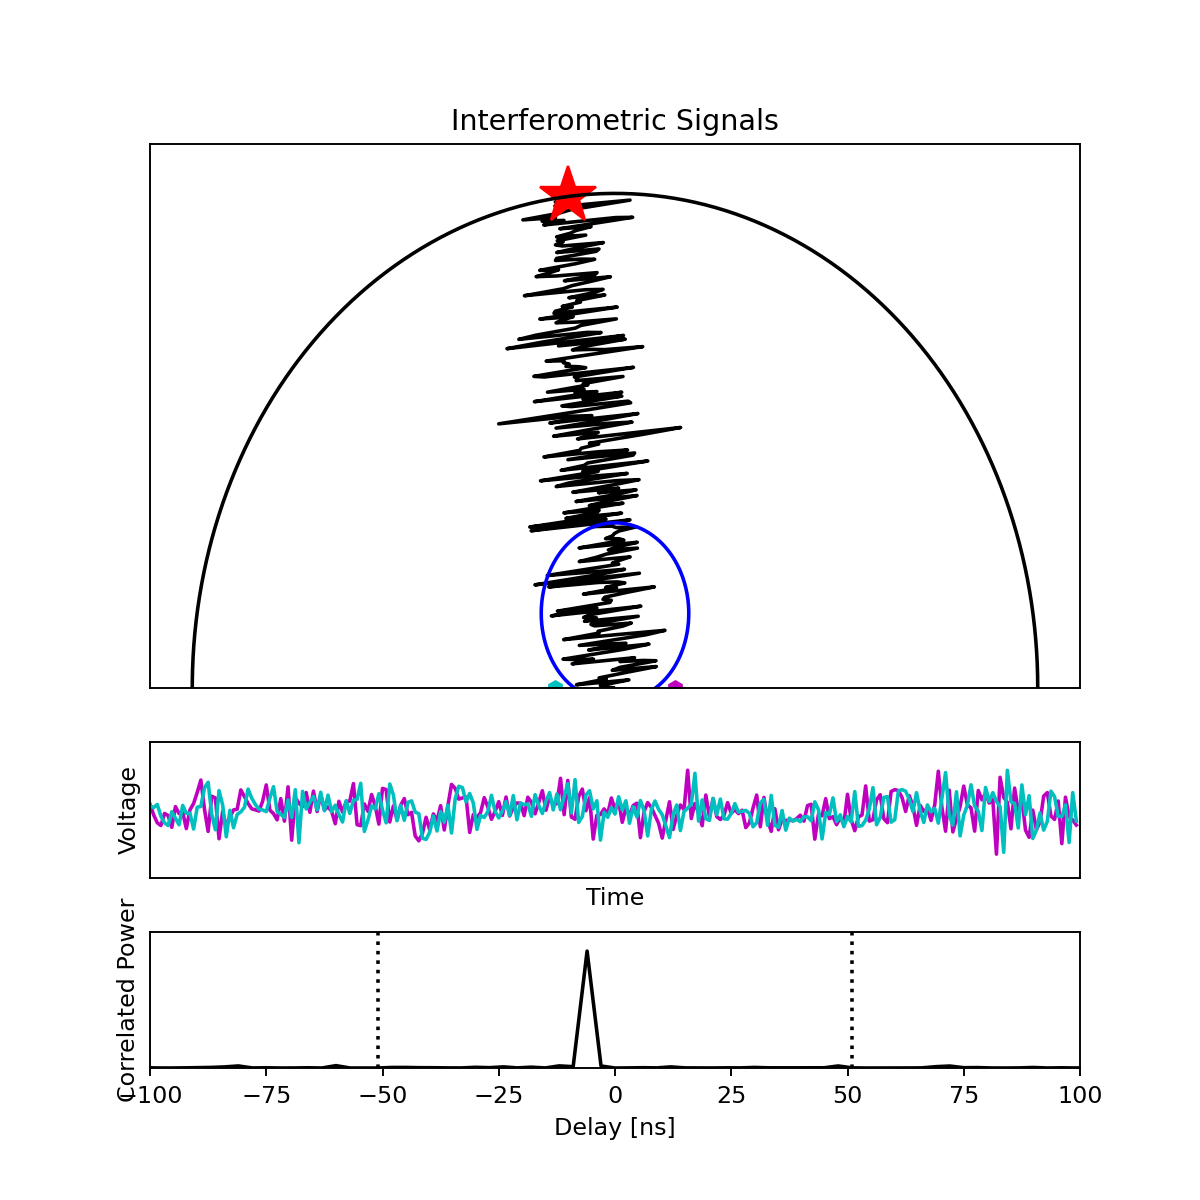

interactive(children=(FloatSlider(value=1.5707963267948966, description='Hour Angle [radians]', layout=Layout(…

In [3]:
# Generate the animation figure

fig = plt.figure(figsize=(7,7))
gs = GridSpec(ncols=1, nrows=3, height_ratios=[4, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

#fig, ax1 = plt.subplots(1, figsize=(8,4))
x, y = radiation
line, = ax1.plot(x, y, 'k') # holds handle for incoming radiation
source, = ax1.plot([0], [RMAX], 'r*', markersize=25) # holds handle for plotting radiating source
beam, = ax1.plot(np.cos(angles)*response, np.sin(angles)*response, 'b')
circle, = ax1.plot(RMAX * np.cos(angles), RMAX * np.sin(angles), 'k')
ant1, = ax1.plot([-5/20], [0], 'ch')
ant2, = ax1.plot([5/20], [0], 'mh')
antenna1, = ax2.plot(signal1, 'm')
antenna2, = ax2.plot(signal2, 'c')
corr, = ax3.plot(np.fft.fftshift(delays), np.fft.fftshift(np.abs(np.fft.ifft(np.fft.fft(signal1) * np.fft.fft(signal2).conj()))**2), 'k')
horizon1, = ax3.plot([-10,-10], [0, 80000], 'k:')
horizon2, = ax3.plot([10,10], [0, 80000], 'k:')

# Slider controlling frequency of charge oscillation
angle_widget = FloatSlider(np.pi/2, min=0, max=np.pi, step=0.01,
                           description='Hour Angle [radians]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
baseline_widget = FloatSlider(10, min=0, max=20.0, step=0.5,
                           description='Baseline Separation [m]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))

def animate(t):
    '''Update plots for each line according to the time step.'''
    th = np.pi - angle_widget.value
    baseline = baseline_widget.value
    amp = 0.2
    sig = radiation[1][0] * response[np.argmin(np.abs(angles - th))]
    receive_signal(radiation[1], baseline, th)
    antenna1.set_ydata(signal1)
    antenna2.set_ydata(signal2)
    corr.set_ydata(np.correlate(signal1, signal2))
    corr.set_ydata(np.fft.fftshift(np.abs(np.fft.ifft(np.fft.fft(signal1) * np.fft.fft(signal2).conj()))**2))
    horizon1.set_xdata([-3*baseline, -3*baseline])
    horizon2.set_xdata([ 3*baseline,  3*baseline])
    radiate()
    x, y = radiation
    plot_x = np.cos(th) * x - np.sin(th) * y * amp
    plot_y = np.sin(th) * x + np.cos(th) * y * amp
    line.set_xdata(plot_x)
    line.set_ydata(plot_y)
    source.set_xdata([RMAX * np.cos(th)])
    source.set_ydata([RMAX * np.sin(th)])
    ant1.set_xdata([-baseline/40])
    ant2.set_xdata([+baseline/40])
    
    
def init():
    '''Set initial plot parameters. Called once by FuncAnimation at beginning.'''
    ax1.set_xlim(-1.1 * RMAX, 1.1 * RMAX)
    ax1.set_ylim(0, 1.1 * RMAX)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.set_ylim(-5,5)
    ax2.set_xlim(0, SIZE)
    ax2.set_xticks([])
    ax2.set_xlabel('Time')
    ax2.set_yticks([])
    ax2.set_ylabel('Voltage')
    ax3.set_ylim(0, 80000)
    ax3.set_xlim(-100,100)
    ax3.set_xlabel('Delay [ns]')
    ax3.set_yticks([])
    ax3.set_ylabel('Correlated Power')
    ax1.set_title('Interferometric Signals')
    return (source, line, beam, antenna1, antenna2)
    
steps = np.linspace(0, 1, NSTEPS) # simulation interval
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)

def build_animation(angle, baseline):
    '''Function which causes FuncAnimation to redraw itself, when freq_widget changes.
    Does not actually hand off the value, but needs to accept an argument tied to
    freq_widget in order to be triggered by updating the slider.'''
    ani.new_frame_seq()

# force animation to redraw when freq_widget changes, even though
# the parameter is not actually passed through (used as global, instead)
interact(build_animation, angle=angle_widget, baseline=baseline_widget)
plt.show()